# CrowdTruth metrics 2.0 documentation

Let:

* $workers(u):$ all workers that annotate media unit $u$;
* $units(i):$ all input media units annotated by worker $i$;
* $WorkVec(i, u):$ annotations of worker $i$ on media unit $u$ as a binary vector;
* $MediaUnitVec(s) = \sum_{i \in workers(s)} WorkVec(i,s)$, where $s$ is an input media unit.

## Media Unit Quality Score (UQS)

The unit quality score $UQS(u)$ is computed as the average cosine similarity between all worker vectors for a given input media unit $u$, weighted by the worker quality ($WQS$) and annotation quality ($AQS$). The goal is to capture the degree of agreement in annotating the media unit. Through the weighted average, workers and annotations with lower quality will have less of an impact on the final score.

$$ UQS(u) = \frac{\sum_{i, j \in workers(u)} Wcos(WorkVec(i,u), WorkVec(j,u)) \; WQS(i) \; WQS(j)}{\sum_{i, j \in workers(u)} WQS(i) \; WQS(j)}, \; i \neq j.$$


### Weighted Cosine

To weigh the metrics with the annotation quality, we compute $Wcos$, the weighted version of the cosine similarity. This metric is only applicable to closed tasks, where annotation quality can be calculated across media units. For open-ended tasks, we consider annotation quality equal to 1 and calculate the regular cosine similarity.

$$ Wcos(vec_1, vec_2) = \frac{\sum_{a} vec_1(a) \; vec_2(a) \; AQS(a)}{\sqrt{(\sum_{a} vec_1^2(a) \; AQS(a)) \; (\sum_{a} vec_2^2(a) \; AQS(a))}} .$$ 


## Worker Quality Score (WQS)

The worker quality score $WQS(i)$ for a given worker $i$ is the product of 2 separate metrics - the worker-worker agreement $WWA(i)$ and the worker-media unit agreement $WUA(i)$.

$$ WQS(i) = WUA(i) \; WWA(i) .$$

### Worker-Media Unit Agreement

The worker-media unit agreement $WUA(i)$ is the average cosine distance between the annotations of a worker $i$ and all annotations for the media units they have worked on, weighted by the media unit and annotation quality. It calculates how much a worker disagrees with the crowd on a media unit basis. Through the weighted average, media units and anntation with lower quality will have less of an impact on the final score.

$$ WSA(i) = \frac{\sum_{u \in units(i)} Wcos(WorkVec(i,u), MediaUnitVec(u) - WorkVec(i, u)) \; UQS(u)}{\sum_{u \in units(i)} UQS(u)} .$$

### Worker-Worker Agreement

The worker-worker agreement $WWA(i)$ is the average cosine distance between the annotations of a worker $i$ and all other workers that have worked on the same media units as worker $i$, weighted by the worker and annotation qualities. The metric gives an indication as to whether there are consisently like-minded workers. This is useful for identifying communities of thought. Through the weighted average, workers and annotations with lower quality will have less of an impact on the final score of the given worker.

$$ WWA(i) = \frac{ \sum_{j \in workers(u \in units(i))} Wcos(WorkVec(i, u), WorkVec(j, u)) \; WQS(j) \; UQS(u) }{ \sum_{j \in workers(s \in units(i))} WQS(j) \; UQS(u) }, \; i \neq j .$$


## Annotation Quality Score (AQS)

The annotation quality score $AQS(a)$ calculates the agreement of selecting an annotation $a$, over all the media units it appears in. Therefore, it is only applicable to closed tasks, where the same annotation set is used for all input media units. It is based on $P_a(i | j)$, the probability that if a worker $j$ annotates $a$ in a media unit, worker $i$ will also annotate it. 

$$ P_a(i | j) = \frac{ \sum_{u \in units(i) \cap units(j) } UQS(u) \; WorkVec(i, s)(r) \; WorkVec(j, s)(r) }{ \sum_{u \in units(i) \cap units(j) } UQS(u) \; WorkVec(j, u)(r) } . $$

$AQS(a)$ is the weighted average of $P_a(i | j)$ for all possible pairs of workers. Through the weighted average, input media units and workers with lower quality will have less of an impact on the final score of the annotation.

$$ AQS(a) = \frac{ \sum_{i,j} WQS(i) \; WQS(j) \; P_a(i | j) }{ \sum_{i,j} WQS(i) \; WQS(j) }, i \neq j . $$


## Media Unit-Annotation Score (UAS)

The media unit - annotation score $UAS(u, a)$ calculates the likelihood that annotation $a$ is expressed in input media unit $u$. It is the ratio of the number of workers that picked annotation $u$ over all workers that annotated the unit, weighted by the worker quality.

$$ UAS(u, a) = \frac{ \sum_{i \in workers(u)} WorkVec(i,u)(a) \; WQS(i) }{ \sum_{i \in workers(u)} WQS(i) }. $$

# How to run the metrics

In [1]:
# Read data
import pandas as pd

pd.set_option('display.max_columns', None)
causal_relations_filename = "crowdflower/causal_relations_main.csv"
causal_relations_dataset = pd.read_csv(causal_relations_filename)

causal_relations_dataset.head(3)

,_unit_id,_created_at,_id,_started_at,_tainted,_channel,_trust,_worker_id,_country,_region,_city,_ip,explanation,hiddeninput,relations,events1,explanation_gold,hiddeninput_gold,pair1,pair2,pair3,pair4,pair5,pair6,relations_gold,sentence1,sentence1_id
0,1540190192,2/1/2018 16:28:22,3322384707,2/1/2018 16:27:47,False,prodege,1,24403612,CAN,ON,Bowmanville,99.244.201.129,NaN,NaN,escorted_85_93-r-suspended_40_49,escorted_85_93###returned_114_122###found_154_...,NaN,NaN,"escorted_85_93, returned_114_122","escorted_85_93, found_154_159","escorted_85_93, suspended_40_49","escorted_85_93, executed_189_197","escorted_85_93, feuding_54_61","escorted_85_93, wounded_251_258",NaN,A Kraft Foods plant worker who had been suspen...,22_14ecbplus.xml_3
1,1540190192,2/1/2018 16:29:31,3322389011,2/1/2018 16:22:19,False,elite,1,43847974,USA,FL,Miami,201.234.224.45,NaN,NaN,escorted_85_93--returned_114_122,escorted_85_93###returned_114_122###found_154_...,NaN,NaN,"escorted_85_93, returned_114_122","escorted_85_93, found_154_159","escorted_85_93, suspended_40_49","escorted_85_93, executed_189_197","escorted_85_93, feuding_54_61","escorted_85_93, wounded_251_258",NaN,A Kraft Foods plant worker who had been suspen...,22_14ecbplus.xml_3
2,1540190192,2/1/2018 16:35:37,3322411943,2/1/2018 16:34:07,False,neodev,1,44227105,USA,MA,Franklin,108.49.108.120,NaN,NaN,"escorted_85_93--returned_114_122,escorted_85_9...",escorted_85_93###returned_114_122###found_154_...,NaN,NaN,"escorted_85_93, returned_114_122","escorted_85_93, found_154_159","escorted_85_93, suspended_40_49","escorted_85_93, executed_189_197","escorted_85_93, feuding_54_61","escorted_85_93, wounded_251_258",NaN,A Kraft Foods plant worker who had been suspen...,22_14ecbplus.xml_3


### Creating a class that inherits from `Configuration` lets us define how the input file will be processed:

* `inputColumns`: list of input columns from the .csv file, the input that the workers were shown
* `outputColumns`: list of output columns with the answers from the workers
* `processJudgments`: function that defines how the worker judgments wil be processed; default separator for judgments is ','

To build the annotation vector, we also need to specify whether this is an **open-ended** or **closed** task, using the `open_ended_task` variable.

* **open-ended task** means that the annotation space is not known, and workers can freely provide all the choices that apply (e.g. in sound tagging, the workers are provided with a text box to enter all tags they can think of)
* **closed task** means that the annotations that can occur in the data are already known, and the workers are asked to validate their existence (e.g. for medical relation extraction, the workers pick from a pre-defined multiple-choice set of relations)

If the task we are processing is **closed**, then we also need to provide the list of possible annotations in the `annotation_vector` variable.

In [2]:
import sys
sys.path.append('../')

stdout = sys.stdout

from defaultconfig import Configuration

class CausalRelationsConfig(Configuration):
    inputColumns = ["index", "number", "events1", "sentence1", "sentence1_id", "pair1", "pair2", "pair3", "pair4", "pair5", "pair6"]
    outputColumns = ["relations"]
    
    # processing of a closed task
    open_ended_task = True
    annotation_vector = [
        "causes", "manifestation", "treats", "prevents", "symptom", "diagnose_by_test_or_drug", "location",
        "side_effect", "contraindicates", "associated_with", "is_a", "part_of", "other", "none"
    ]
    
    column_separator = ","
        
    def processJudgments(self, judgments):
        # change default separator to whitespace to make it work with our file
        #for col in self.outputColumns:
        #    judgments[col] = judgments[col].apply(lambda x: x.replace('no_relation', 'no_causal_relation'))
        #    judgments[col] = judgments[col].apply(lambda x: x.replace(' ', ','))
        return judgments

config = CausalRelationsConfig()

### Pre-process the data and create the annotation vectors


In [3]:
from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename=causal_relations_filename,
    config=config
)

1 iterations; max d= 1.0 ; wqs d= 0.805304493352; sqs d= 0.666922509721; rqs d= 0.0
2 iterations; max d= 0.309501221156 ; wqs d= 0.0678871568557; sqs d= 0.0615259886157; rqs d= 0.0
3 iterations; max d= 0.0679286267049 ; wqs d= 0.00918833756688; sqs d= 0.0106945744781; rqs d= 0.0
4 iterations; max d= 0.0222019350174 ; wqs d= 0.00322143792087; sqs d= 0.00320935105676; rqs d= 0.0
5 iterations; max d= 0.0192927195068 ; wqs d= 0.000805284333326; sqs d= 0.00101479762834; rqs d= 0.0
6 iterations; max d= 0.0100535290689 ; wqs d= 0.000396130804592; sqs d= 0.000387006159003; rqs d= 0.0
7 iterations; max d= 0.00810214333715 ; wqs d= 0.000182587921738; sqs d= 0.000228789510792; rqs d= 0.0
8 iterations; max d= 0.00580859970537 ; wqs d= 0.000117953908546; sqs d= 0.000133551269011; rqs d= 0.0
9 iterations; max d= 0.00436259750729 ; wqs d= 7.62986885155e-05; sqs d= 9.49347320658e-05; rqs d= 0.0
10 iterations; max d= 0.00327505584567 ; wqs d= 5.41066152217e-05; sqs d= 6.59013815337e-05; rqs d= 0.0
11 i

### Run the metrics

In [4]:
sys.stdout = stdout

# run the metrics
from models import Metrics
processed_results = Metrics.run(pre_processed_results, config)

In [5]:
processed_results["units"]

,duration,input.events1,input.pair1,input.pair2,input.pair3,input.pair4,input.pair5,input.pair6,input.sentence1,input.sentence1_id,job,metrics.avg_annotations,metrics.avg_cos_clarity,metrics.avg_unique_annotations,output.relations,output.relations.annotations,output.relations.cos_clarity,output.relations.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial
unit,,,,,,,,,,,,,,,,,,,,,,,
1528104351,49.333333,wins_96_100###victory_30_37###coming_101_107##...,"wins_96_100, victory_30_37","wins_96_100, coming_101_107","wins_96_100, knockout_118_126","wins_96_100, improves_69_77","victory_30_37, coming_101_107","victory_30_37, knockout_118_126",This was Klitschko ’ s second victory over Tho...,7_7ecbplus.xml_34,crowdflower/causal_relations_main,35.0,0.634811,8.0,"{u'wins_96_100--victory_30_37': 5, u'wins_96_1...",35,0.634811,8,15,0.386899,{u'wins_96_100--victory_30_37': 0.265140688859...,0.319984,{u'wins_96_100--victory_30_37': 0.333333333333...
1528104352,47.866667,wins_96_100###victory_30_37###coming_101_107##...,"victory_30_37, improves_69_77","coming_101_107, knockout_118_126","coming_101_107, improves_69_77","knockout_118_126, improves_69_77",NaN,NaN,This was Klitschko ’ s second victory over Tho...,7_7ecbplus.xml_34,crowdflower/causal_relations_main,24.0,0.759072,4.0,"{u'victory_30_37--improves_69_77': 11, u'victo...",24,0.759072,4,15,0.582021,{u'victory_30_37--improves_69_77': 0.774410265...,0.522028,{u'victory_30_37--improves_69_77': 0.733333333...
1528104353,63.000000,waved_70_75###rise_30_34###managed_19_26,"waved_70_75, rise_30_34","waved_70_75, managed_19_26","rise_30_34, managed_19_26",NaN,NaN,NaN,"To his credit , he managed to rise to his feet...",7_7ecbplus.xml_33,crowdflower/causal_relations_main,19.0,0.628971,5.0,"{u'rise_30_34-r-managed_19_26': 5, u'rise_30_3...",19,0.628971,5,15,0.288422,{u'rise_30_34-r-managed_19_26': 0.413098987713...,0.281291,{u'rise_30_34-r-managed_19_26': 0.333333333333...
1528104354,90.666667,recovered_15_24###round_88_93###hand_42_46,"recovered_15_24, round_88_93","recovered_15_24, hand_42_46","round_88_93, hand_42_46",NaN,NaN,NaN,Thompson never recovered from a big right hand...,7_8ecbplus.xml_6,crowdflower/causal_relations_main,21.0,0.666667,7.0,"{u'recovered_15_24--hand_42_46': 2, u'no_relat...",21,0.666667,7,15,0.228996,{u'recovered_15_24--hand_42_46': 0.13669743336...,0.227634,{u'recovered_15_24--hand_42_46': 0.13333333333...
1528104355,81.600000,challenge_67_76###met_14_17###round_99_104,"challenge_67_76, met_14_17","challenge_67_76, round_99_104","met_14_17, round_99_104",NaN,NaN,NaN,"Thompson last met Wladimir Klitschko in 2008 ,...",7_8ecbplus.xml_10,crowdflower/causal_relations_main,19.0,0.796030,5.0,"{u'challenge_67_76-r-met_14_17': 4, u'no_relat...",19,0.796030,5,15,0.325528,{u'challenge_67_76-r-met_14_17': 0.21670877842...,0.298789,{u'challenge_67_76-r-met_14_17': 0.26666666666...
1528104356,96.533333,extended_29_37###run_51_54,"extended_29_37, run_51_54",NaN,NaN,NaN,NaN,NaN,The Ukrainian world champion extended his unbe...,7_8ecbplus.xml_5,crowdflower/causal_relations_main,17.0,0.894427,3.0,"{u'extended_29_37--run_51_54': 4, u'extended_2...",17,0.894427,3,15,0.473609,"{u'extended_29_37--run_51_54': 0.236639815546,...",0.448973,"{u'extended_29_37--run_51_54': 0.266666666667,..."
1528104357,38.666667,retained_19_27###round_133_138###stopping_77_85,"retained_19_27, round_133_138","retained_19_27, stopping_77_85","round_133_138, stopping_77_85",NaN,NaN,NaN,"Wladimir Klitschko retained his WBA , IBF and ...",7_8ecbplus.xml_4,crowdflower/causal_relations_main,16.0,0.985527,3.0,"{u'retained_19_27-r-stopping_77_85': 13, u'rou...",16,0.985527,3,15,0.844764,{u'retained_19_27-r-stopping_77_85': 0.9376830...,0.718907,{u'retained_19_27-r-stopping_77_85': 0.8666666...
1528104358,81.466667,hit_39_42###contest_8_15,"hit_39_42, contest_8_15",NaN,NaN,NaN,NaN,NaN,And the contest was over when Thompson hit the...,7_8ecbplus.xml_7,crowdflower/causal_relations

### Plot the unit quality score (UQS) at the beginning of the process and at the end

Text(0,0.5,u'# Units')

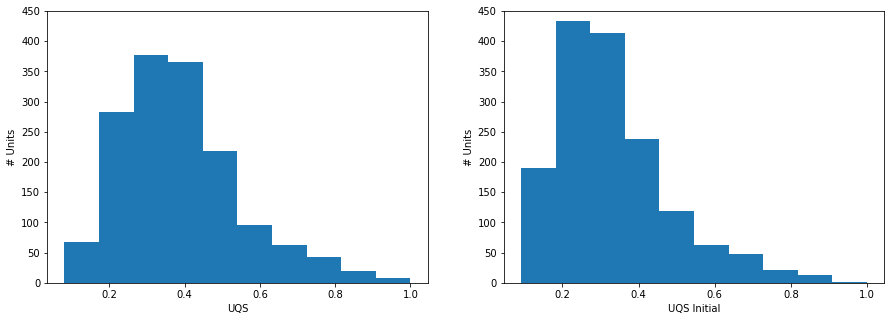

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = 15, 5

plt.subplot(1, 2, 1)
plt.hist(processed_results["units"]["uqs"])
plt.ylim(0, 450)
plt.xlabel("UQS")
plt.ylabel("# Units")

plt.subplot(1, 2, 2)
plt.hist(processed_results["units"]["uqs_initial"])
plt.ylim(0, 450)
plt.xlabel("UQS Initial")
plt.ylabel("# Units")

### Plot the change in unit qualtity score at the beginning of the process and at the end

In [7]:
sortUQS = processed_results["units"].sort(['uqs'], ascending=[1])
sortUQS = sortUQS.reset_index()

Text(0.5,0,u'Sentence Index')

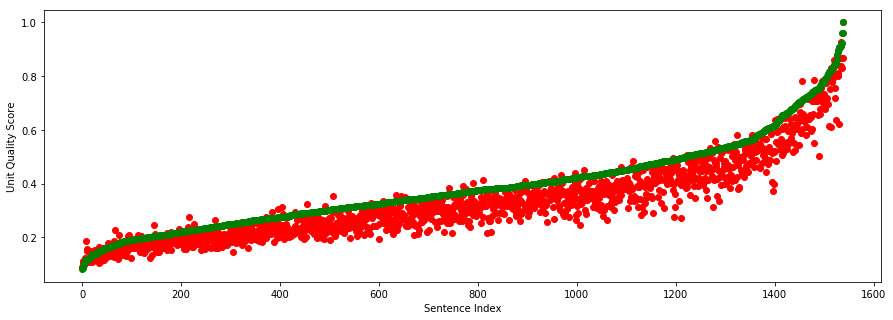

In [8]:
import numpy as np

plt.rcParams['figure.figsize'] = 15, 5

plt.plot(np.arange(sortUQS.shape[0]), sortUQS["uqs_initial"], 'ro', lw = 1, label = "Initial UQS")
plt.plot(np.arange(sortUQS.shape[0]), sortUQS["uqs"], 'go', lw = 1, label = "Final UQS")

plt.ylabel('Unit Quality Score')
plt.xlabel('Sentence Index')


### Plot the worker quality score (UQS) at the beginning of the process and at the end



In [9]:
processed_results["workers"].head(10)

,worker-cosine,job,output.relations.count,duration,judgment,unit,worker-agreement,spam,wqs,wqs_initial
worker,,,,,,,,,,
1855113,0.476636,1,1.887640,50.674157,89,89,0.276326,False,0.229319,0.179749
1863467,0.582086,1,1.066667,52.133333,15,15,0.262189,False,0.165357,0.109995
1883056,0.403105,1,2.160256,46.750000,156,156,0.260416,False,0.298885,0.222155
1914041,0.575783,1,1.000000,28.000000,15,15,0.297531,False,0.120349,0.109977
1924522,0.540982,1,1.131148,24.557377,61,61,0.295976,False,0.218853,0.141357
2171654,0.254766,1,1.200000,55.333333,15,15,0.497012,False,0.577920,0.421138
3587109,0.554509,1,1.000000,18.021277,141,141,0.256737,False,0.186183,0.124868
3671372,0.656278,1,1.000000,22.933333,15,15,0.118916,False,0.088546,0.060148
3696575,0.420657,1,1.500000,49.250000,4,4,0.337384,False,0.282104,0.221869


Text(0,0.5,u'# Workers')

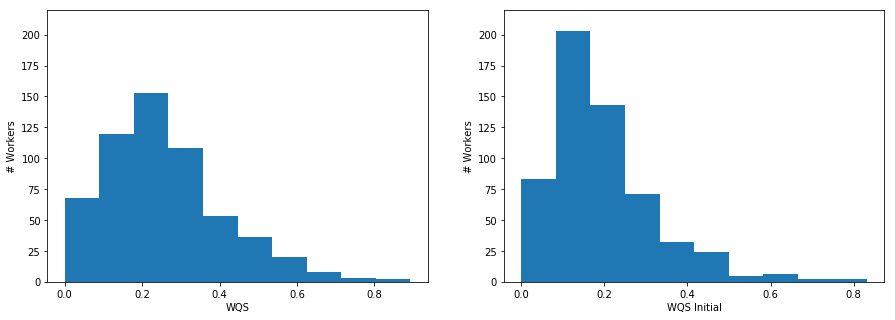

In [10]:
plt.rcParams['figure.figsize'] = 15, 5

plt.subplot(1, 2, 1)
plt.hist(processed_results["workers"]["wqs"])
plt.ylim(0, 220)
plt.xlabel("WQS")
plt.ylabel("# Workers")

plt.subplot(1, 2, 2)
plt.hist(processed_results["workers"]["wqs_initial"])
plt.ylim(0, 220)
plt.xlabel("WQS Initial")
plt.ylabel("# Workers")

### Plot the change in worker qualtity score at the beginning of the process and at the end


In [11]:
sortWQS = processed_results["workers"].sort(['wqs'], ascending=[1])
sortWQS = sortWQS.reset_index()
sortWQS.head(10)

,worker,worker-cosine,job,output.relations.count,duration,judgment,unit,worker-agreement,spam,wqs,wqs_initial
0,39226056,1.000000,1,1.000000,271.000000,1,1,0.000000,True,0.000000,0.000000
1,8715359,0.939916,1,1.000000,176.000000,1,1,0.071429,False,0.002364,0.004292
2,43923861,0.917239,1,1.000000,66.000000,1,1,0.071429,False,0.003443,0.005911
3,44214817,0.823105,1,2.375000,21.375000,8,8,0.062869,False,0.011243,0.012523
4,6082058,0.805193,1,2.666667,91.000000,3,3,0.047531,False,0.011500,0.015179
5,43975211,0.715940,1,1.000000,58.466667,15,15,0.168318,False,0.014925,0.055459
6,44022928,0.669387,1,1.000000,13.142857,7,7,0.161565,False,0.015644,0.077593
7,43971951,0.650592,1,1.000000,24.333333,9,9,0.190994,False,0.016091,0.080419
8,44209263,0.811018,1,2.000000,28.000000,1,1,0.071429,False,0.016226,0.019090
9,42577934,0.819802,1,1.058824,39.941176,17,17,0.048548,False,0.018313,0.016384


Text(0.5,0,u'Worker Index')

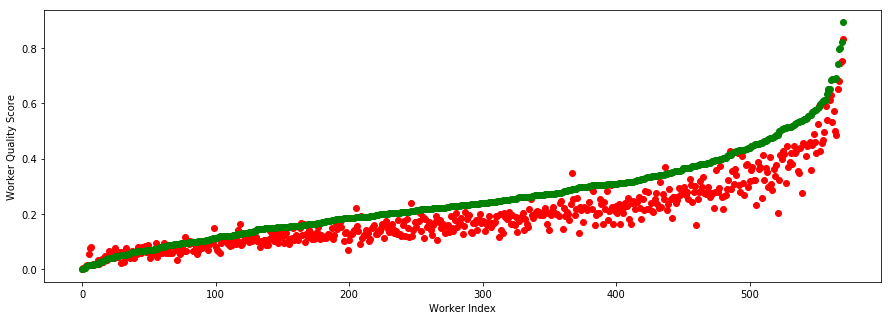

In [12]:
plt.rcParams['figure.figsize'] = 15, 5

plt.plot(np.arange(sortWQS.shape[0]), sortWQS["wqs_initial"], 'ro', lw = 1, label = "Initial UQS")
plt.plot(np.arange(sortWQS.shape[0]), sortWQS["wqs"], 'go', lw = 1, label = "Final UQS")

plt.ylabel('Worker Quality Score')
plt.xlabel('Worker Index')
#plt.legend(loc=9, bbox_to_anchor=(0.5, 1.2), ncol=3, prop={'size':12})


In [13]:
sortWQS.to_csv("Results/main_workers_withoutAnnotationQuality.csv", index=False)

In [14]:
sortUQS

,unit,duration,input.events1,input.pair1,input.pair2,input.pair3,input.pair4,input.pair5,input.pair6,input.sentence1,input.sentence1_id,job,metrics.avg_annotations,metrics.avg_cos_clarity,metrics.avg_unique_annotations,output.relations,output.relations.annotations,output.relations.cos_clarity,output.relations.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial
0,1535612049,76.400000,Riots_0_5###storm_148_153###hurled_167_173###e...,"storm_148_153, hurled_167_173","storm_148_153, engulfed_73_81","storm_148_153, tried_139_144","storm_148_153, dead_64_68","storm_148_153, torched_206_213","hurled_167_173, engulfed_73_81",Riots over harsh new austerity measures left t...,8_3ecbplus.xml_3,crowdflower/causal_relations_main,21.0,0.571429,11.0,"{u'storm_148_153-r-tried_139_144': 1, u'storm_...",21,0.571429,11,15,0.080785,{u'storm_148_153-r-tried_139_144': 0.082234843...,0.091251,{u'storm_148_153-r-tried_139_144': 0.066666666...
1,1535613003,82.866667,made the round_44_58###clashes_75_82###spread_...,"clashes_75_82, spread_94_100","clashes_75_82, tried_195_200","clashes_75_82, death_17_22","clashes_75_82, gathered_143_151","clashes_75_82, visit_204_209","spread_94_100, tried_195_200",After the tragic death of the three workers ma...,8_6ecbplus.xml_16,crowdflower/causal_relations_main,17.0,0.624695,9.0,"{u'no_relation': 1, u'clashes_75_82--spread_94...",17,0.624695,9,15,0.087750,"{u'no_relation': 0.0883081010442, u'clashes_75...",0.103128,"{u'no_relation': 0.0666666666667, u'clashes_75..."
2,1540162757,75.933333,doing_97_102###shot_74_78###attempted_48_57###...,"doing_97_102, shot_74_78","doing_97_102, attempted_48_57","doing_97_102, determined_211_221","doing_97_102, yard work_103_112","doing_97_102, convicted_16_25","doing_97_102, shooting_183_191","Orozco was also convicted of the June 20 , 200...",16_2ecbplus.xml_14,crowdflower/causal_relations_main,19.0,0.583460,10.0,"{u'doing_97_102-r-shooting_183_191': 1, u'no_r...",19,0.583460,10,15,0.090964,{u'doing_97_102-r-shooting_183_191': 0.0672780...,0.113207,{u'doing_97_102-r-shooting_183_191': 0.0666666...
3,1540137353,93.400000,handle_57_63###attorney_32_40###re - hired_12_...,"handle_57_63, attorney_32_40","handle_57_63, re - hired_12_22","handle_57_63, case_68_72","attorney_32_40, re - hired_12_22","attorney_32_40, case_68_72","re - hired_12_22, case_68_72",The actress re - hired longtime attorney Shawn...,1_8ecbplus.xml_4,crowdflower/causal_relations_main,17.0,0.624695,9.0,"{u'handle_57_63--attorney_32_40': 2, u'no_rela...",17,0.624695,9,15,0.098427,{u'handle_57_63--attorney_32_40': 0.2263615037...,0.108707,{u'handle_57_63--attorney_32_40': 0.1333333333...
4,1540216466,69.133333,fight_207_212###close_235_240###stopping_145_1...,"close_235_240, stopping_145_153","close_235_240, defending_68_77","close_235_240, won_19_22","close_235_240, round_196_201","close_235_240, fight_41_46","stopping_145_153, defending_68_77",Wladimir Klitschko won his 16th straight fight...,7_5ecbplus.xml_3,crowdflower/causal_relations_main,20.0,0.577350,11.0,"{u'stopping_145_153-r-defending_68_77': 2, u'c...",20,0.577350,11,15,0.105201,"{u'close_235_240-r-won_19_22': 0.292454443425,...",0.104906,"{u'close_235_240-r-won_19_22': 0.266666666667,..."
5,1540168694,189.666667,lying_168_173###performing_98_108###killed_85_...,"murder_159_165, murder_44_50","murder_159_165, attempted_259_268","murder_159_165, wait_177_181","murder_159_165, murder_122_128","murder_244_250, circumstances_27_40","murder_244_250, commit_233_239",It also found true special circumstances of mu...,16_2ecbplus.xml_7,crowdflower/causal_relations_main,20.0,0.577350,11.0,"{u'murder_244_250--circumstances_27_40': 1, u'...",20,0.577350,11,15,0.111916,{u'murder_244_250--circumstances_27_40': 0.122...,0.104068,{u'murder_244_250--circumstances_27_40': 0.066...
6,1535612087,96.266667,made_345_349###marking_25_32###referring_182_1...,"referring_182_191, march_204_209","referring_182_191, march_19_24","referring

In [15]:
rows = []
header = list(sortUQS)
header.extend(["event-event_pair", "no_of_annotations", "event-event_pair_final_score", "event-event_pair_initial_score"])

rows.append(header)

for i in range(len(sortUQS.index)):
    keys = []
    keys.append(str(sortUQS["input.pair1"].iloc[i]).replace(', ', '--'))
    keys.append(str(sortUQS["input.pair1"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair2"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair2"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair2"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair3"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair3"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair3"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair4"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair4"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair4"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair5"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair5"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair5"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair6"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair6"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair6"].iloc[i]).replace(', ', '-r-'))
    keys.append("no_causal_relation")
    
    for j in range(len(keys)):
        row = list(sortUQS.iloc[i])
        row.append(keys[j])
        #if (keys[j] not in sortUQS["output.relations"].iloc[i]):
        #    print(keys[j])
        row.append(sortUQS["output.relations"].iloc[i][keys[j]])
        row.append(sortUQS["unit_annotation_score"].iloc[i][keys[j]])
        row.append(sortUQS["unit_annotation_score_initial"].iloc[i][keys[j]])
    
        rows.append(row)

In [16]:
import csv

with open('Results/main_annotations_withoutAnnotationQuality.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows)
    

# Adding the annotation quality 

In [17]:
# extract the annotation vector components

import pandas as pd

crowd_noOffset = pd.read_csv("crowdflower/causal_relations_main_noOffset.csv")
annotations = list(pd.concat([crowd_noOffset['pair1_noOffset'], crowd_noOffset['pair2_noOffset'], 
                         crowd_noOffset['pair3_noOffset'], crowd_noOffset['pair4_noOffset'], 
                         crowd_noOffset['pair5_noOffset'], crowd_noOffset['pair6_noOffset']]).unique())

cleanedList = [x for x in annotations if pd.isnull(x) != True]

final_vector = []
for item in cleanedList:
    final_vector.append(item.replace(', ', '--'))
    final_vector.append(item.replace(', ', '-r-'))
final_vector.append('no_relation')  

len(final_vector)

9351

In [18]:
import sys
sys.path.append('../')

from defaultconfig import Configuration

class CausalRelationsConfig(Configuration):
    inputColumns = ["index", "number", "events1", "sentence1", "sentence1_id", "pair1", "pair2", "pair3", "pair4", "pair5", "pair6", "pair1_noOffset", "pair2_noOffset", "pair3_noOffset", "pair4_noOffset", "pair5_noOffset", "pair6_noOffset"]
    outputColumns = ["relations_noOffset"]
    
    # processing of a closed task
    open_ended_task = False
    annotation_vector = final_vector
    
    column_separator = ","
    
    def processJudgments(self, judgments):
        # change default separator to whitespace to make it work with our file
        for col in self.outputColumns:
            #judgments[col] = judgments[col].apply(lambda x: x.replace('no_relation', 'no_causal_relation'))
            judgments[col] = judgments[col].apply(lambda x: x.replace('\n', ','))
        return judgments

config = CausalRelationsConfig()

In [ ]:
from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename="crowdflower/causal_relations_main_noOffset.csv",
    config=config
)

crowdflower/causal_relations_main_noOffset.csv: [##--------] 15.0%is not dict
escorted-r-suspended


In [ ]:
# run the metrics
from models import Metrics
processed_results_noOffsets = Metrics.run(pre_processed_results, config)

In [ ]:
len(final_vector)